
---
## Linear Quadratic Model Predictive Control

*Perform Model Predictive Control (MPC) on linear system dynamics by converting the MPC optimization problem to a quadratic cost problem. The new problem is optimized using the Operator Splitting Quadratic Program (OSQP).*

**Jake Miller and Kyle Johnsen**  
**SIP Lab**   
**Georgia Institute of Technology**  

---

#### Imports

We make use of [OSQP](https://osqp.org/docs/index.html) in order to calculate optimal trajectories. OSQP does not have to be directly imported, but is used within LQMPC. Scipy is used for efficient sparse matrix operations.

In [1]:
import lqmpc
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

#### Dynamics

In our example, we take a linear dynamical system describing the spiking behavior of a population of neurons.

$$ x_{t+1} = Ax_{t} + Bu_{t} $$

$$ y_{t} = Cx_{t} + Du_{t} $$

We take $x\in\mathbb{R}^n$, $u\in\mathbb{R}^m$, and $y\in\mathbb{R}^o$.

In [2]:
A = np.array([[1, -6.66e-13, -2.03e-9, -4.14e-6],                               # System matrix (n x n)
              [9.83e-4, 1, -4.09e-8, -8.32e-5],
              [4.83e-7, 9.83e-4, 1, -5.34e-4],
              [1.58e-10, 4.83e-7, 9.83e-4, .9994]])
B = np.array([[9.83e-4, 4.83e-7, 1.58e-10, 3.89e-14]]).T                        # Control matrix (n x m)
C = np.array([[-.0096, .0135, .005, -.0095]])                                   # Output matrix (o x n)

n, m = B.shape
t_step = 0.001                                                                  # Dynamics for 1 ms

#### Cost Function

We define a cost function which includes the ability to have a state penalty, input penalty, and differential input penalty. The state penalties occur over the prediction horizon while the input penalties over the control horizon. MPC subjects this cost function to particular constraints:

$$ J^{MPC} = \sum_{i=1}^N (x_i-x_{r_i})^TQ(x_i-x_{r_i}) + \sum_{i=1}^M u_i^TRu_i + \Delta u_i^T S \Delta u_i $$

$$ x_{i+1} = Ax_{i} + Bu_{i} $$

$$ x_{min} \leq x \leq x_{max} $$

$$ u_{min} \leq u \leq u_{max} $$

$$ x_1 = x_0 $$

where $ N $ is the prediction horizon, $M$ the control horizon, $Q$ the state penalty matrix, $R$ the input penalty matrix, $S$ the differential input penalty matrix, $x_r$ the reference state, and $x_0$ a varying initial state provided on each step. To calculate the first differential input $\Delta u_1=u_1-u_0$, an initial input $u_0$ will be defined only for the calculation of cost.

In [3]:
N = 25                                                                          # Prediction horizon

Q = C.T@C                                                                       # State penalty
R = sparse.eye(m)*1e-6                                                          # Input penalty 

umin = np.array([0])                                                            # Lower input bound                                     
umax = np.array([10])                                                           # Upper input bound

x0 = np.zeros(n)                                                                # Initial state
u0 = np.zeros(m)                                                                # Initial input

#### Reference

When using LQMPC, state references can be supplied per step or for a full simulation loop. For this example, we aim to clamp the output spiking rate, represented with a peri-stimulus time histogram (PSTH), to a sine reference. We use a non-linear function to convert the control ouput to the PSTH.

We will define our reference for the full loop. The reference is defined on the $t_{step}$ scale but sampled from on the $t_{sim}$ scale. We will simulate for $L=120$ simulation steps, so we must define the reference with length $(L+N)(t_{sim}/t_{step})$.

In [4]:
L = 120                                                                         # Number of simulation steps
t_sim = 0.25                                                                    # Simulation time step in seconds
ref_len = (L + N)*int(t_sim/t_step)                                             # Length of reference

def z_to_y(z):
    # From PSTH to output
    return (np.log(z)+5.468)/61.4
def y_to_z(y):
    # From output to PSTH
    return np.exp(61.4*np.array(y)-5.468)

inv = np.linalg.inv
I = np.eye(4)

zr = 0.1 * np.sin(np.linspace(0,2*np.pi,ref_len) * 8) + 0.2                     # Sine reference
yr = z_to_y([zr])
ur = inv(C@inv(I-A)@B)@yr
xr = inv(I-A)@B@ur                                                              # Full reference state

#### Simulate

Now that we have prepared all the necessary inputs, we can simulate the system with control dynamics. There is also an option to print out how long it takes to run a simulation step or full loop.

Simulation Time: 5.69786501 s 
Mean Step Time: 0.04748221 s 



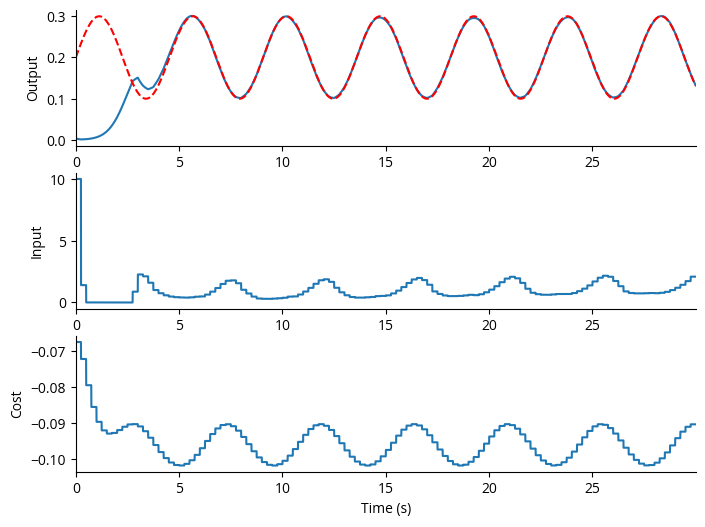

In [5]:
mpc = lqmpc.LQMPC(t_step,A,B,C)                                             # Instantiate object with dynamics
mpc.set_control(Q=Q,R=R,N=N,M=20)                                               # Set the control parameters
mpc.set_constraints(umin=umin,umax=umax)                                        # Set the constraints
mpc.simulate(t_sim,x0,u0,xr,L)                                                  # Perform a full simulation loop
mpc.plot(f=y_to_z)                                                              # Plot the results

#### Step

The simulate function utilizes the step function within the control loop, but what if you want to simulate one step at a time? Here, we explain the step function more closely. The step function takes as input a simulation step time $t_{sim}$, an initial state $x_0$ and initial input $u_0$, a reference $x_r$ defined for at least $N\times n_{sim}$ many steps, and a boolean on whether any additional output should be printed to the terminal.

The step function returns the [result](https://osqp.org/docs/interfaces/python.html) of OSQP's **solve()** method.

Cost: -0.06743034519371201


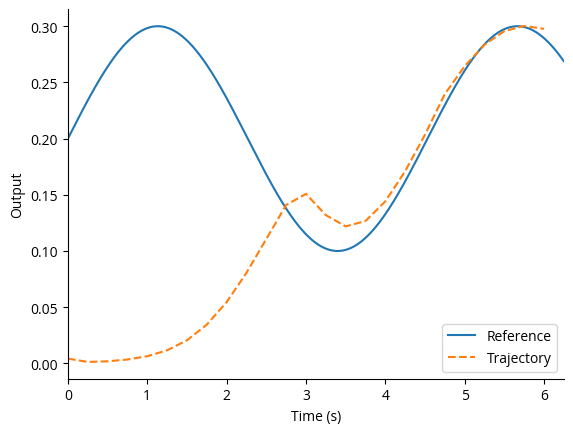

In [6]:
n_sim = int(t_sim/t_step)                                                       # Number of points per simulation step
xr_step = xr[:,:N*n_sim]                                                        # Reference for step    
zr_step = y_to_z(C@xr_step).T                                                   # Convert to output reference

result = mpc.step(t_sim, x0, u0, xr_step, out=False)                            # Step function

trajectory = result.x                                                           
state_traj = trajectory[0:N*n]                                                  # State trajectory
output_traj = y_to_z(C@np.reshape(state_traj,(N,4)).T).T                        # Convert to output trajectory
control_traj = trajectory[N*n:]                                                 # Control moves

cost = result.info.obj_val                                                      # Objective value
print('Cost:', cost)

t_r = np.arange(0,len(zr_step)) * t_step                                        # Time series for reference
t_z = np.arange(0,len(output_traj)) * t_sim                                     # Time series for state trajectory

plt.plot(t_r,zr_step)                                                           # Plot the optimal trajectory
plt.plot(t_z,output_traj,'--')
plt.xlim([0, N*t_sim])
plt.legend(['Reference','Trajectory'])
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.show()

---

### Formulation

This section will explain the conversion from the Model Predictive Control problem to a quadratic problem. We use OSQP to solve the cost function, but in order to utilize OSQP, we must provide the proper parameters for a quadratic problem. In contrast to our MPC definition shown previously, OSQP uses the following:

$$ J^{OSQP} = \frac{1}{2}x^TPx + q^Tx $$

$$ l \leq Ax \leq u $$

where $P$ and $q$ represent the objective function, $l$ and $u$ represent lower and upper bounds, and $A$ defines the linear constraints on $x$. There are no longer sums, so the MPC problem must be computed with matrix operations.

The variable $x$ now contains all $N$ states over the prediction horizon and all $M$ inputs over the control horizon. Hence, $x\in\mathbb{R}^{Nn+Mm}$.

#### Penalties

We will start with encoding the penalties Q, R, and S into P.

$$ P = \begin{bmatrix} P_x & 0 \\ 0 & P_u \end{bmatrix} $$

$$ P_x = I^{N\times N}\otimes Q $$

$$ P_u = I^{M\times M}\otimes R + I^{M\times M}\otimes 2S + I_{-1,1}^{M\times M}\otimes -S $$

$I$ denotes the identity matrix and $I_{-1,1}$ denotes the matrix with all zeros except for ones on the primary subdiagonals. The $2S$ allows each input $u_i$ to be used twice for two different differentials: $\Delta u_i=u_i-u_{i-1}$ and $\Delta u_{i+1}=u_{i+1}-u_{i}$. Hence, the last $u_M$ is needed only once, so we subtract $S$ from the bottom right block of $P_u$. 

For $N = 5$ and $M=3$, we exemplify $Px$:

$$ Px=
\begin{bmatrix} 
Q & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & Q & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & Q & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & Q & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & Q & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & R + 2S & -S & 0 \\
0 & 0 & 0 & 0 & 0 & -S & R + 2S & -S \\
0 & 0 & 0 & 0 & 0 & 0 & -S & R + S 
\end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \\ u_1 \\ u_2 \\ u_3 \end{bmatrix}
$$

Our cost function also has a term linear in $x$, $q$, where we can define the cost of deviating from the reference since $x_r$ is not accounted for in $x^TPx$. We exemplify $q$ for $N=5$ and $M=3$ as:

$$ 
\begin{bmatrix} -2Qx_{r_1} \\ -2Qx_{r_2} \\ -2Qx_{r_3} \\ -2Qx_{r_4} \\ -2Qx_{r_5} \\ -2Su_{0} \\ 0 \\ 0 \end{bmatrix}
$$

where $q\in\mathbb{R}^{Nn+Mm}$. We will now show that our new matrix-based structure of the cost function $J^{OSQP}$ is consistent with the summation definition of our MPC cost function $J^{MPC}$.

We can compute the cost for $i=1$ of $J^{MPC}$:

$$ J^{MPC} = \sum_{i=1}^N (x_i-x_{r_i})^TQ(x_i-x_{r_i}) + \sum_{i=1}^M u_i^TRu_i + \Delta u_i^T S \Delta u_i $$

$$ J_{1}^{MPC} = x_1^TQx_1-x_1^TQx_{r_1}-x_{r_1}^TQx_1+x_{r_1}^TQx_{r_1} + u_1^TRu_1 + u_1^TSu_1-u_1^TSu_0-u_0^TSu_1+u_0^TSu_0$$

Now, if we compute $x^TPx+q^Tx$ for $x_1$ and $u_1$ we see:

$$ x^TPx = x_1^TQx_1+u_1^TRu_1+2u_1^TSu_1 -u_1^TSu_2-u_2^TSu_1 $$

$$ q^Tx = -2x_{r_1}^TQx_1 -2u_0^TSu_1 $$

when $Q$ and $S$ are symmetric. As we are just checking the $x_1$ and $u_1$ calculation, we ignore one of the two $u_1^TSu_1$ and the $u_2$ terms which are used in $i=2$ to calculate $\Delta u_2^TS\Delta u_2$. We can also use the property that $a^TMb=b^TMa$ to expand the matrix cost function:

$$ J_{1}^{OSQP} = x_1^TQx_1+u_1^TRu_1+u_1^TSu_1 -x_{r_1}^TQx_1 - x_1^TQx_{r_1} -u_0^TSu_1-u_1^TSu_0$$

Observe that our two equations for $J_1$ have identical terms except for that we are missing the terms $x_{r_1}^TQx_{r_1}$ and $u_0^TSu_0$. However, these are just constants, and thus do not effect the optimization problem and can be left out. The only impact is the the actual value computed for the costs will often be negative, but this does not significantly effect the solver.

A final note for the cost function calculation is that in our implementation, we multiply $P$ by $2$ to negate the $\frac{1}{2}$ provided by the OSQP solver.

#### Constraints

Now we must encode the four constraint conditions for the MPC problem into a single set of inequalities $l\leq Ax\leq u$. Two of the constraints are equalities and two are inequalities. The two inequality constraints describe the upper and lower bounds defined for the state and input variables.

$$ l_{ineq} = \begin{bmatrix} 1^N \otimes x_{min} \\ 1^M \otimes u_{min} \end{bmatrix} $$

$$ u_{ineq} = \begin{bmatrix} 1^N \otimes x_{max} \\ 1^M \otimes u_{max} \end{bmatrix} $$

which makes $l_{ineq},u_{ineq}\in\mathbb{R}^{Nn+Mm}$. Then we define $A_{ineq}=I^{(Nn+Mm)\times(Nn+Mm)}$. So we now have the constraint equation:

$$ l_{ineq} \leq A_{ineq} x \leq u_{ineq} $$

This satisfies constraints on the values for the state and input, but we must also let the solver know that $x_{i+1}= Ax_i +Bu_i$. So, we will use matrix operations to force the equation $0=Ax_i+Bu_i-x_{i+1}=0$. So we define:

$$ l_{eq} = u_{eq} = \begin{bmatrix} x_0 \\ 0^{(N-1)n+Mm} \end{bmatrix} $$

$$ A_{eq} = \begin{bmatrix} A_x & B_u \end{bmatrix} $$

where $A_x$ will describe $Ax_i$ and $B_u$ will describe $Bu_i$. Before we continue, we make an aside to describe a speed-up used to simplify the amount of computation required by the solver. Instead of defining an $x_i$ and $u_i$ for every system time step, we define it for only every simulation or control time step. For example:

$$ x_3 = Ax_2 + Bu_2 $$

$$ x_2 = Ax_1 + Bu_1 $$

$$ x_3 = A^2x_1+(A+I)Bu_1 $$

If our simulation step takes $n_{sim}$ many system time steps, we define:

$$ x_{n_{sim}} = A^{n_{sim}-1}x_1 = A_{x_s}x_1 $$

$$ u_{n_{sim}} = \left(\sum_{i=0}^{n_{sim}-2} A^i\right)Bu_1 = A_{u_s} Bu_1$$

Now we are ready to define $A_x$ and $B_u$ for $A_{eq}$.

$$ A_x = I^{N\times N} \otimes I^{n\times n} - I_{-1}^{N\times N} \otimes A_{x_s} $$

$$ B_u = \begin{bmatrix} 0^{1\times M} \\ I^{M\times M} \\ \begin{bmatrix} 0^{(N-M-1)\times(M-1)} & 1^{N-M-1} \end{bmatrix}  \end{bmatrix} \otimes A_{u_s}B $$

How this produces the equality constraints is much clearer if we exemplify $A_{eq}$ for $N=5$ and $M=3$:

$$ A_{eq}x=
\begin{bmatrix} 
I & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
-A_{x_s} & I & 0 & 0 & 0 & A_{u_s}B & 0 & 0 \\
0 & -A_{x_s} & I & 0 & 0 & 0 & A_{u_s}B & 0 \\
0 & 0 & -A_{x_s} & I & 0 & 0 & 0 & A_{u_s}B \\
0 & 0 & 0 & -A_{x_s} & I & 0 & 0 & A_{u_s}B 
\end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \\ u_1 \\ u_2 \\ u_3 \end{bmatrix}= 
\begin{bmatrix} x_0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}=l_{eq}=u_{eq}
$$

We can see that as standard with a control horizon, after we have computed $M$ control inputs, the final steps in the prediction horizon will keep the last input constant. This matrix will also enforce that $x_1=x_0$. 

To combine the equality constraints and inequality constraints into one, we simply stack vertically:

$$ l = \begin{bmatrix} l_{eq} \\ l_{ineq} \end{bmatrix}, u = \begin{bmatrix} u_{eq} \\ u_{ineq} \end{bmatrix}, A = \begin{bmatrix} A_{eq} \\ A_{ineq} \end{bmatrix} $$

$$ l \leq Ax \leq u $$

with $l,u\in\mathbb{R}^{2Nn+Mm}$ and $A\in\mathbb{R}^{(2Nn+Mm)\times(Nn+Mm)}$.

---
